In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import hotspot

In [2]:
ctc = sc.read_h5ad('ctc_heterogeneity.h5ad')

In [3]:
ctc

AnnData object with n_obs × n_vars = 261 × 12557
    obs: 'total_counts', 'pct_counts_mt', 'pct_counts_rb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'chip_id', 'patient_info', 'phage_info', '_scvi_batch', '_scvi_labels', 'leiden', 'anno', 'chip_color', 'anno_ctc'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'anno_colors', 'anno_ctc_colors', 'chip_id_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [ ]:
# hotspot works a lot faster with a csc matrix!
ctc.layers['counts_csc'] = ctc.layers['counts'].tocsc()

In [ ]:
# Create the Hotspot object and the neighborhood graph
hs = hotspot.Hotspot(
    ctc,
    layer_key="counts_csc",
    model='danb',
    latent_obsm_key="X_scVI",
    umi_counts_obs_key='total_counts'
)

In [6]:
hs.create_knn_graph(
    weighted_graph=False, n_neighbors=30,
)

In [7]:
hs_results = hs.compute_autocorrelations(jobs=4)

hs_results.head(15)

100%|██████████| 12557/12557 [00:09<00:00, 1344.70it/s]


,C,Z,Pval,FDR
Gene,,,,
AC090204.1,0.399533,58.833261,0.000000e+00,0.000000e+00
FP236383.1,0.481468,58.405639,0.000000e+00,0.000000e+00
MTRNR2L5,0.570675,58.251144,0.000000e+00,0.000000e+00
MTRNR2L1,0.593049,57.685776,0.000000e+00,0.000000e+00
GSE1,0.505987,55.737026,0.000000e+00,0.000000e+00
ERBB4,0.497746,47.586286,0.000000e+00,0.000000e+00
AC007547.3,0.440414,47.543017,0.000000e+00,0.000000e+00
MTCO3P13,0.431793,46.311774,0.000000e+00,0.000000e+00
MYRIP,0.409730,45.015269,0.000000e+00,0.000000e+00


In [8]:
# Select the genes with significant lineage autocorrelation
hs_genes = hs_results.loc[hs_results.FDR < 0.05].sort_values('Z', ascending=False).head(500).index

In [9]:
# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=4)

Computing pair-wise local correlation on 500 features...


100%|██████████| 124750/124750 [00:33<00:00, 3754.83it/s]


In [10]:
modules = hs.create_modules(
    min_gene_threshold=15, core_only=True, fdr_threshold=0.05
)

modules.value_counts()

Module
-1     139
 3     106
 4      42
 5      41
 1      30
 9      27
 2      18
 8      17
 10     17
 6      16
 7      16
 11     16
 12     15
Name: count, dtype: int64

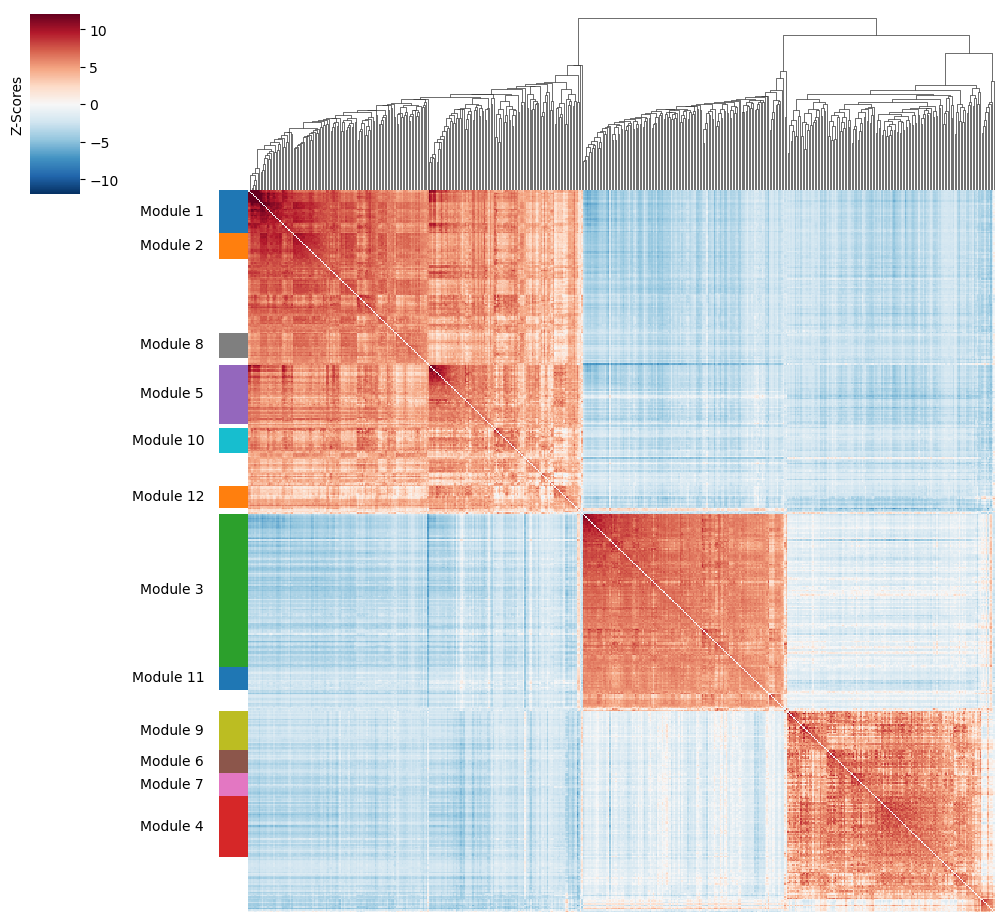

In [11]:
hs.plot_local_correlations(vmin=-12, vmax=12)

In [12]:
module_scores = hs.calculate_module_scores()

module_scores.head()

Computing scores for 12 modules...


100%|██████████| 12/12 [00:00<00:00, 16.41it/s]


,1,2,3,4,5,6,7,8,9,10,11,12
404.0-Y00784ME_2,-3.247313,-2.048594,6.933405,-2.006827,-2.442167,-1.095449,-1.110337,-1.388660,-1.289047,-1.133197,3.024328,-0.830243
516.0-Y00784ME_2,6.498510,3.347393,-3.212151,-1.785945,2.294633,-0.960036,-1.118020,2.306813,-1.203647,3.184205,-0.813324,0.471289
511.0-Y00784ME_2,3.635664,1.393427,-2.852671,-1.664682,2.997228,-0.972047,-1.126711,1.002803,-1.088785,1.257021,-0.559199,1.792153
547.0-Y00784ME_2,1.671107,0.639251,-2.210337,-1.688033,2.088628,-0.987374,-1.028665,0.106017,-1.091526,-0.146613,-0.144958,2.565187
727.0-Y00784ME_2,3.043255,1.415830,-2.792179,-1.893517,1.803942,-0.863031,-1.149531,0.752413,-1.027810,0.918337,-0.625588,1.334324


In [13]:
module_cols = []
for c in module_scores.columns:
    key = f"Module {c}"
    ctc.obs[key] = module_scores[c]
    module_cols.append(key)

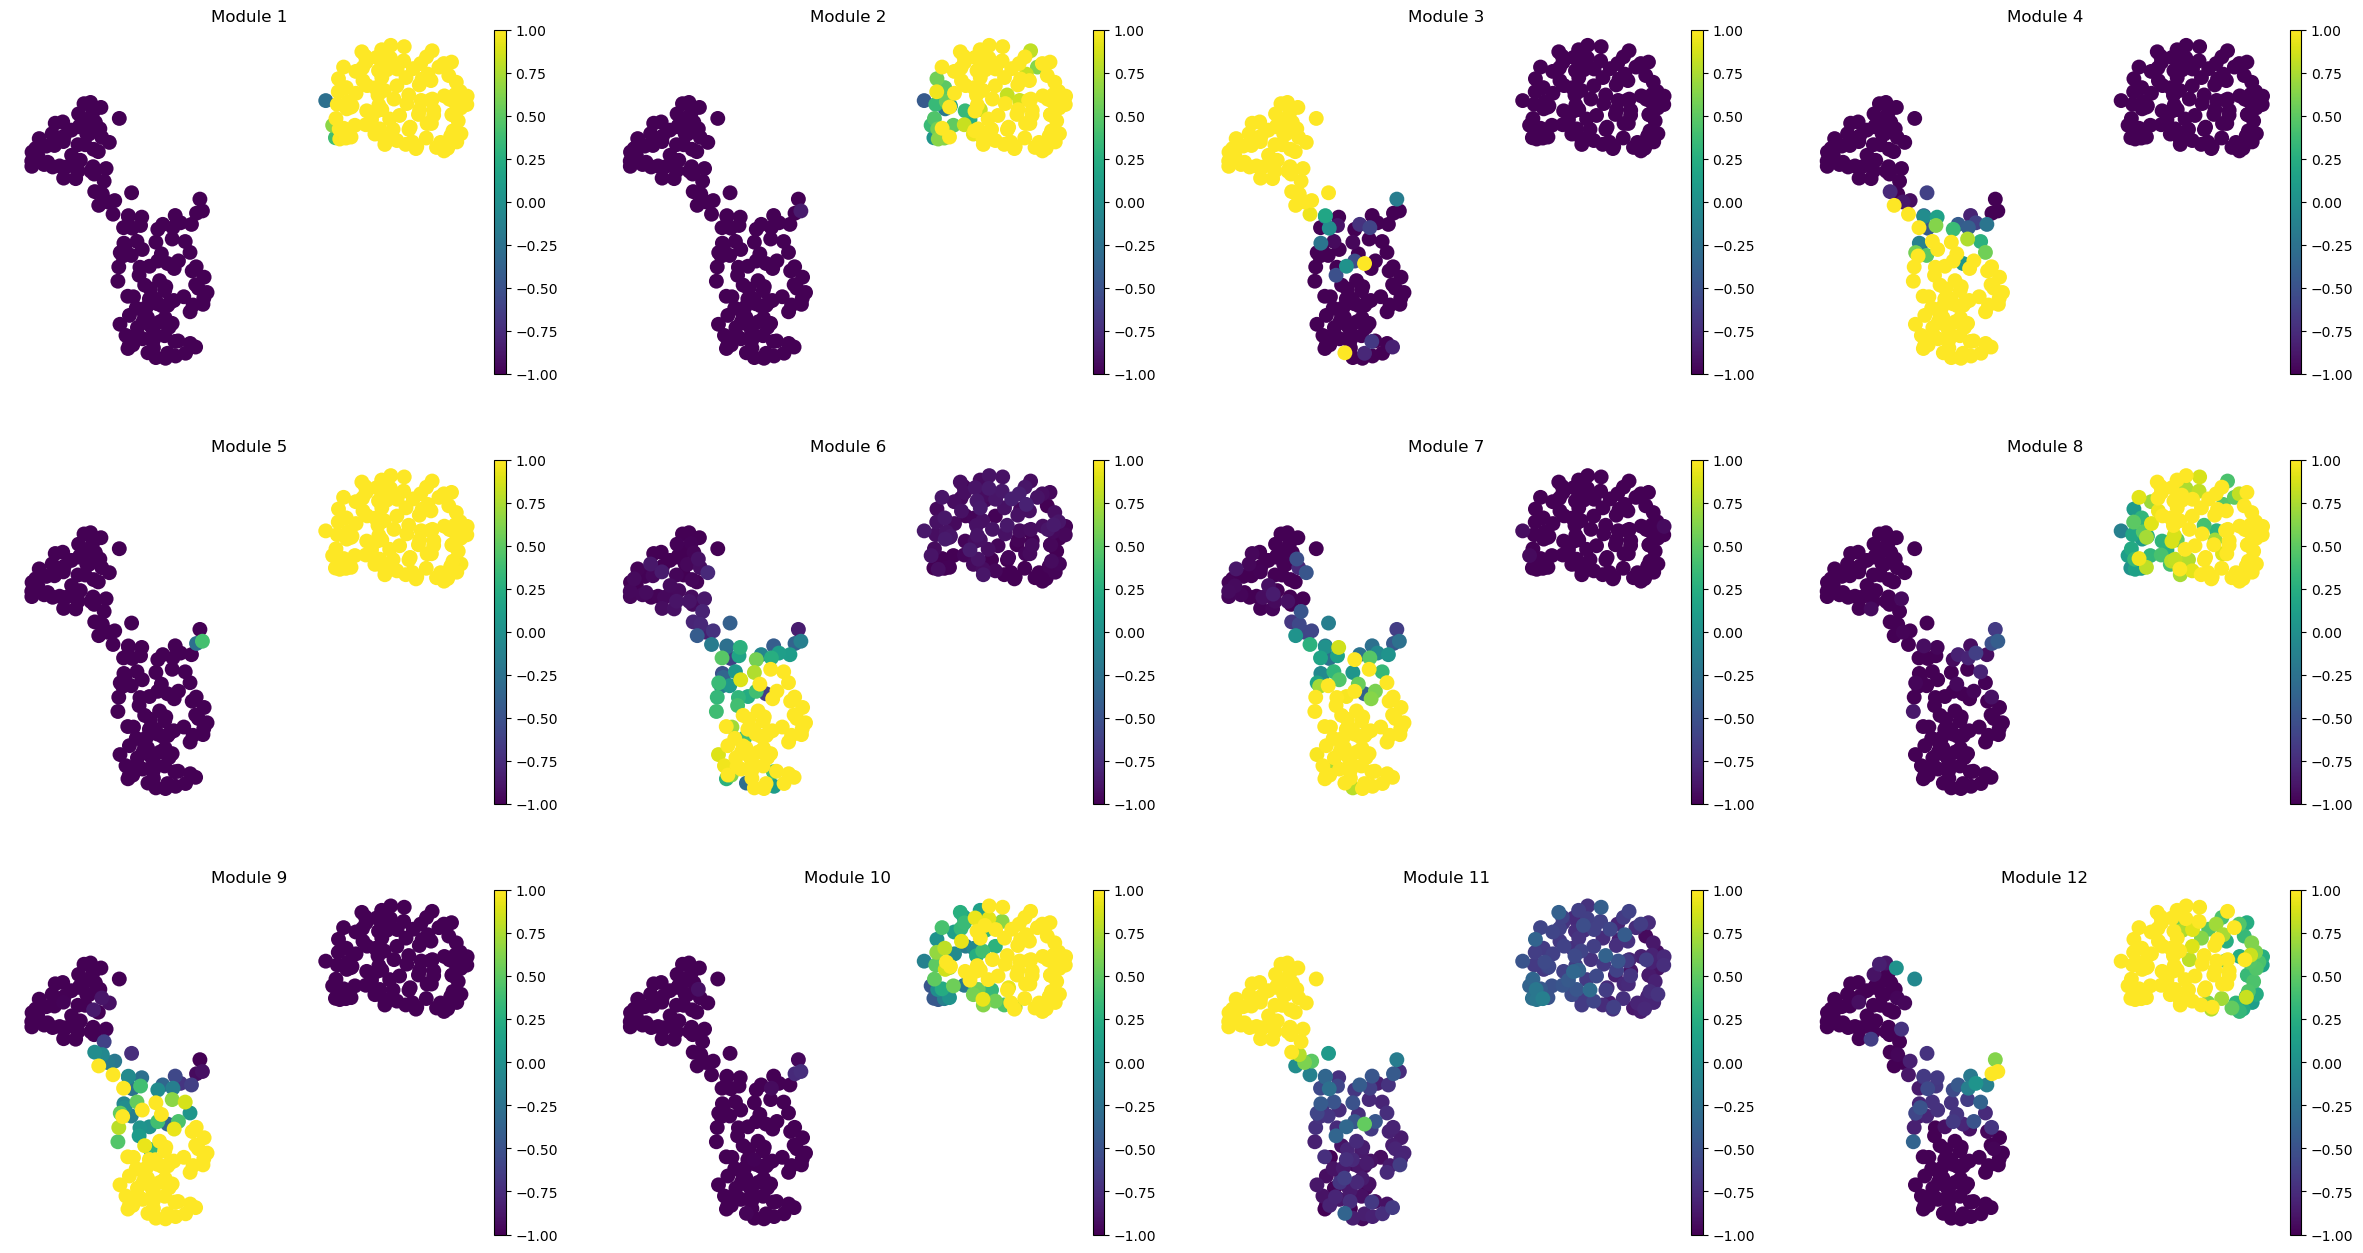

In [14]:
sc.pl.umap(ctc, color=module_cols, frameon=False, vmin=-1, vmax=1)

In [15]:
# Show the top genes for a module

module = 9

results = hs.results.join(hs.modules)
results = results.loc[results.Module == module]

results.sort_values('Z', ascending=False).head(10)

,C,Z,Pval,FDR,Module
Gene,,,,,
ASTN2,0.085180,13.028590,4.207442e-39,2.855830e-37,9.0
GABRA5,0.047561,11.024366,1.457836e-28,7.564482e-27,9.0
AC106793.1,0.050248,10.371976,1.662885e-25,7.820544e-24,9.0
DSCAM,0.111287,10.296080,3.669575e-25,1.694076e-23,9.0
UNC5D,0.098046,10.204140,9.499863e-25,4.245188e-23,9.0
RILPL1,0.077094,10.140351,1.828914e-24,8.058131e-23,9.0
ROR2,0.105619,9.915224,1.787267e-23,7.531111e-22,9.0
DNAH8,0.069986,9.863266,3.003174e-23,1.244583e-21,9.0
HS6ST3,0.059112,9.583363,4.696768e-22,1.866371e-20,9.0


In [23]:
module_df = hs.results.join(hs.modules)
module_df.head()

,C,Z,Pval,FDR,Module
Gene,,,,,
AC090204.1,0.399533,58.833261,0.0,0.0,1.0
FP236383.1,0.481468,58.405639,0.0,0.0,1.0
MTRNR2L5,0.570675,58.251144,0.0,0.0,1.0
MTRNR2L1,0.593049,57.685776,0.0,0.0,1.0
GSE1,0.505987,55.737026,0.0,0.0,1.0


In [25]:
import gseapy as gp

for i in range(12):
    i = i + 1
    gene_list = module_df[module_df['Module'] == i].index.tolist()
    enr = gp.enrichr(
        gene_list=gene_list,
        gene_sets=['GO_Biological_Process_2025', 'GO_Molecular_Function_2025', 'GO_Cellular_Component_2025'],
    )

    enr.results.to_csv(f'/mnt/c/Users/ouyangkang/Desktop/module_{i}.csv')